In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("injury_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
# Create Player column correctly as done in the initial processing
df["Player"] = df["Acquired"].fillna(df["Relinquished"])
df = df.dropna(subset=["Player"])
df = df.sort_values(["Player", "Date"]).reset_index(drop=True)

In [ ]:
def get_season(date):
    year = date.year
    return f"{year}_{year+1}" if date.month >= 10 else f"{year-1}_{year}"

df["season"] = df["Date"].apply(get_season)

valid_seasons = [
    "2020_2021", "2021_2022", "2022_2023",
    "2023_2024", "2024_2025"
]

df = df[df["season"].isin(valid_seasons)]


In [ ]:
def classify_injury(notes):
    if pd.isna(notes):
        return "IL_only"

    n = notes.lower()

    severe = ["acl", "achilles", "fracture", "rupture", "surgery", "torn"]
    moderate = ["sprain", "strain", "concussion", "back", "knee", "ankle"]

    if any(t in n for t in severe):
        return "Severe"
    if any(t in n for t in moderate):
        return "Moderate"
    return "IL_only"


In [ ]:
df["injury_type"] = df["Notes"].apply(classify_injury)


In [ ]:
injury_events = []

for player_name, group in df.groupby("Player"):
    group = group.reset_index(drop=True)

    start_date = None
    start_type = None
    season = None

    for _, row in group.iterrows():
        if row["Relinquished"] == player_name:
            start_date = row["Date"]
            start_type = row["injury_type"]
            season = row["season"]

        elif row["Acquired"] == player_name and start_date is not None:
            end_date = row["Date"]
            duration = (end_date - start_date).days

            injury_events.append({
                "Name": player_name,
                "season": season,
                "duration_days": duration,
                "injury_type": start_type
            })

            start_date = None
            start_type = None
            season = None

In [ ]:
events_df = pd.DataFrame(injury_events)


In [ ]:
def duration_score(days):
    if days <= 3:
        return 0.25
    elif days <= 7:
        return 0.5
    elif days <= 21:
        return 1.0
    else:
        return 2.0


In [ ]:
type_weight = {
    "IL_only": 0.4,      # rest / precaution
    "Moderate": 1.0,
    "Severe": 2.0
}


In [ ]:
events_df["event_score"] = (
    events_df["duration_days"].apply(duration_score)
    * events_df["injury_type"].map(type_weight)
)


In [ ]:
season_scores = (
    events_df
    .groupby(["Name", "season"])["event_score"]
    .sum()
    .unstack(fill_value=0)
)


In [ ]:
for col in season_scores.columns:
    max_val = season_scores[col].max()
    if max_val > 0:
        season_scores[col] = (season_scores[col] / max_val) * 100


In [ ]:
counts = (
    events_df
    .groupby("Name")["injury_type"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={
        "Severe": "severe_count",
        "Moderate": "moderate_count",
        "IL_only": "minor_count"
    })
)


In [ ]:
final_df = (
    counts
    .join(season_scores, how="outer")
    .fillna(0)
    .reset_index()
)


In [ ]:
final_df

,Name,minor_count,moderate_count,severe_count,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025
0,(James) Mike Scott,1,3,0,39.393939,0.000000,0.000000,0.000000,0.0
1,A.J. Green,2,1,2,0.000000,0.000000,30.303030,25.196850,2.0
2,A.J. Griffin,3,0,0,0.000000,0.000000,0.000000,20.472441,0.0
3,A.J. Johnson,0,0,1,0.000000,0.000000,0.000000,0.000000,20.0
4,Aaron Gordon,10,10,0,33.333333,9.210526,21.969697,22.834646,65.0
...,...,...,...,...,...,...,...,...,...
727,Zach LaVine,5,10,0,9.848485,54.605263,5.303030,12.598425,17.0
728,Zeke Nnaji,2,7,0,15.151515,56.578947,37.878788,15.748031,0.0
729,Ziaire Williams,5,2,0,0.000000,15.131579,6.060606,9.448819,0.0
730,Zion Williamson,8,4,0,9.090909,0.000000,13.636364,8.661417,44.0


In [ ]:
output_file = "player_injury_scores_2020_2025.csv"

final_df.to_csv(output_file, index=False)

print(f"File saved as {output_file}")


In [ ]:
from google.colab import files

files.download(output_file)


In [ ]:
import pandas as pd
import numpy as np

final_df = pd.read_csv("player_injury_scores_2020_2025.csv")


In [ ]:
seasons = [
    "2020_2021",
    "2021_2022",
    "2022_2023",
    "2023_2024",
    "2024_2025"
]


In [ ]:
for season in seasons:
    score_col = f"score_{season}"
    gp_col = f"GamesPlayed_{season}"

    if gp_col in final_df.columns:
        final_df.loc[
            final_df[gp_col] == 0,
            score_col
        ] = 100


In [ ]:
final_df["has_severe_injury"] = final_df["severe_count"] > 0


In [ ]:
season_duration = (
    events_df
    .groupby(["Name", "season"])["duration_days"]
    .sum()
    .reset_index(name="total_days_missed")
)


In [ ]:
final_df = final_df.merge(
    season_duration,
    how="left",
    on="Name"
)

final_df["total_days_missed"] = final_df["total_days_missed"].fillna(0)


In [ ]:
for season in seasons:
    score_col = season # Changed from f"score_{season}"

    final_df.loc[
        (final_df["total_days_missed"] <= 30) &
        (final_df["severe_count"] == 0) &
        (final_df[score_col] > 60),
        score_col
    ] = 60

In [ ]:
final_df.loc[
    final_df["Name"].isin(["Stephen Curry", "LeBron James", "Luka Doncic"]),
    ["Name"] + seasons + ["total_days_missed"]
]


,Name,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,total_days_missed


In [ ]:
final_df

,Name,minor_count,moderate_count,severe_count,2020_2021,2021_2022,2022_2023,2023_2024,2024_2025,has_severe_injury,season,total_days_missed
0,(James) Mike Scott,1,3,0,39.393939,0.000000,0.000000,0.000000,0.0,False,2020_2021,27
1,A.J. Green,2,1,2,0.000000,0.000000,30.303030,25.196850,2.0,True,2022_2023,18
2,A.J. Green,2,1,2,0.000000,0.000000,30.303030,25.196850,2.0,True,2023_2024,12
3,A.J. Green,2,1,2,0.000000,0.000000,30.303030,25.196850,2.0,True,2024_2025,2
4,A.J. Griffin,3,0,0,0.000000,0.000000,0.000000,20.472441,0.0,False,2023_2024,39
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,Zion Williamson,8,4,0,9.090909,0.000000,13.636364,8.661417,44.0,False,2020_2021,6
1826,Zion Williamson,8,4,0,9.090909,0.000000,13.636364,8.661417,44.0,False,2022_2023,17
1827,Zion Williamson,8,4,0,9.090909,0.000000,13.636364,8.661417,44.0,False,2023_2024,9
1828,Zion Williamson,8,4,0,9.090909,0.000000,13.636364,8.661417,44.0,False,2024_2025,61


In [ ]:
output_file = "player_injury_score_2020_2025.csv"

final_df.to_csv(output_file, index=False)

print(f"File saved as {output_file}")


File saved as player_injury_score_2020_2025.csv


In [ ]:
from google.colab import files

files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaned:


In [ ]:
import pandas as pd
import numpy as np

# Load dataset (skip if already loaded)
final_df = pd.read_csv("player_injury_score_2020_2025.csv")

# Define seasons
all_seasons = ["2020_2021","2021_2022","2022_2023","2023_2024","2024_2025"]

# Create full player-season grid
players = final_df["Name"].unique()
full_index = pd.MultiIndex.from_product(
    [players, all_seasons],
    names=["Name", "season"]
)

# Reindex dataset → ensures missing seasons exist
final_df = (
    final_df
    .set_index(["Name","season"])
    .reindex(full_index)
    .reset_index()
)


In [ ]:
# Assume full season ≈ 170 days missed
FULL_SEASON_DAYS = 170

# If total_days_missed is NaN → treat as full season missed
final_df["total_days_missed"] = final_df["total_days_missed"].fillna(FULL_SEASON_DAYS)

# Fill injury counts
for col in ["minor_count","moderate_count","severe_count"]:
    final_df[col] = final_df[col].fillna(0)

# Severe injury flag
final_df["has_severe_injury"] = final_df["has_severe_injury"].fillna(True)


/tmp/ipython-input-2568157729.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df["has_severe_injury"] = final_df["has_severe_injury"].fillna(True)


In [ ]:
# Example: if your injury score column is "injury_score"
# (change name if different)

FULL_SEASON_THRESHOLD = 160

final_df.loc[
    final_df["total_days_missed"] >= FULL_SEASON_THRESHOLD,
    "injury_score"
] = 100


In [ ]:
# NBA season ≈ 82 games / 170 days
final_df["games_missed"] = (
    final_df["total_days_missed"] / 170 * 82
).clip(upper=82)


In [ ]:
# Sort for lag creation
final_df = final_df.sort_values(["Name","season"])

# Create lag feature
final_df["games_missed_last_season"] = (
    final_df.groupby("Name")["games_missed"].shift(1)
)


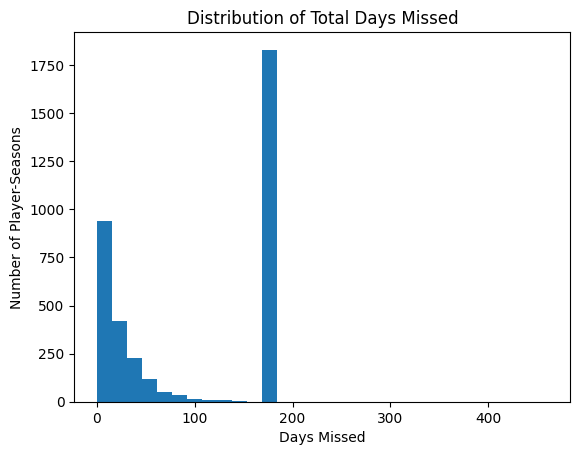

In [ ]:
import matplotlib.pyplot as plt

plt.hist(final_df["total_days_missed"], bins=30)
plt.title("Distribution of Total Days Missed")
plt.xlabel("Days Missed")
plt.ylabel("Number of Player-Seasons")
plt.show()


In [ ]:
final_df.to_csv("player_injury_score_2020_2025_cleaned.csv", index=False)


In [ ]:
output_file = "player_injury_score_2020_2025_cleaned.csv"

final_df.to_csv(output_file, index=False)

print(f"File saved as {output_file}")


File saved as player_injury_score_2020_2025_cleaned.csv


In [ ]:
from google.colab import files

files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model:

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score


# ===============================
# LOAD DATA
# ===============================

df = pd.read_csv("player_injury_score_2020_2025_cleaned.csv")


# ===============================
# SORT DATA (important for time features)
# ===============================

df = df.sort_values(["Name", "season"])


# ===============================
# CREATE NEXT SEASON TARGET
# ===============================

# shift games missed forward → next season injury
df["games_missed_next_season"] = (
    df.groupby("Name")["games_missed"].shift(-1)
)

# classification target
df["target"] = (df["games_missed_next_season"] >= 20).astype(int)


# ===============================
# DROP LAST SEASON (no future label)
# ===============================

df = df.dropna(subset=["games_missed_next_season"])


# ===============================
# FEATURES (baseline)
# ===============================

feature_cols = [
    "games_missed",
    "games_missed_last_season",
    "total_days_missed",
    "minor_count",
    "moderate_count",
    "severe_count",
    "has_severe_injury"
]

X = df[feature_cols].fillna(0)
y = df["target"]


# ===============================
# TRAIN / TEST SPLIT
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ===============================
# MODEL PIPELINE
# ===============================

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])


# ===============================
# TRAIN MODEL
# ===============================

model.fit(X_train, y_train)


# ===============================
# EVALUATION
# ===============================

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_prob))


# ===============================
# SAVE MODEL
# ===============================

os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/injury_clf.pkl")

print("\n✅ Model saved → models/injury_clf.pkl")



Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.40      0.49       241
           1       0.67      0.85      0.75       345

    accuracy                           0.66       586
   macro avg       0.66      0.62      0.62       586
weighted avg       0.66      0.66      0.64       586

ROC AUC: 0.6737266221660954

✅ Model saved → models/injury_clf.pkl


Improved model:

In [ ]:
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

# -----------------------------
# LOAD DATA
# -----------------------------
df = pd.read_csv("player_injury_score_2020_2025.csv")

# -----------------------------
# SORT BY PLAYER + TIME
# -----------------------------
df = df.sort_values(["Name", "season"])

# -----------------------------
# CREATE LAG FEATURES (PAST HISTORY)
# -----------------------------
df["prev_days_missed"] = df.groupby("Name")["total_days_missed"].shift(1)
df["prev_severe"] = df.groupby("Name")["has_severe_injury"].shift(1)

# drop first season rows
df = df.dropna()

# -----------------------------
# TARGET = CURRENT SEASON INJURY
# -----------------------------
df["injury_label"] = (df["total_days_missed"] > 15).astype(int)

# -----------------------------
# FEATURES (ONLY PAST INFO)
# -----------------------------
features = [
    "minor_count",
    "moderate_count",
    "severe_count",
    "prev_days_missed",
    "prev_severe"
]

X = df[features]
y = df["injury_label"]

# -----------------------------
# TRAIN TEST SPLIT
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -----------------------------
# TRAIN XGBOOST
# -----------------------------
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

# -----------------------------
# EVALUATE
# -----------------------------
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, prob))




In [ ]:
# -----------------------------
# SAVE
# -----------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/injury_xgb.pkl")

print("✅ Clean model saved")